In [1]:
from lmfit.models import GaussianModel
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import pandas as pd

In [2]:
tds = pd.read_pickle("reduced/tds_phase_1.pkl")
tds

,time,tds_image,is_beam_on,l1_chrip_phase,charge
0,2021-02-21 00:30:17.046674013,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 4, 13, ...",True,-7.0,0.24685
1,2021-02-21 00:30:22.084268093,"[[12, 5, 4, 4, 14, 6, 0, 0, 1, 14, 9, 0, 0, 12...",False,-7.0,NaN
2,2021-02-21 00:30:25.301686049,"[[0, 12, 0, 0, 14, 0, 18, 18, 11, 0, 24, 9, 0,...",False,-7.0,NaN
3,2021-02-21 00:30:28.509352922,"[[0, 0, 3, 0, 15, 9, 0, 0, 9, 0, 22, 18, 17, 0...",False,-7.0,NaN
4,2021-02-21 00:30:31.663580894,"[[2, 0, 0, 0, 15, 11, 0, 0, 30, 0, 0, 0, 0, 11...",False,-7.0,NaN
...,...,...,...,...,...
191,2021-02-21 00:41:28.365645170,"[[0, 6, 1, 0, 17, 1, 0, 13, 0, 0, 13, 0, 0, 0,...",True,5.0,0.24900
192,2021-02-21 00:41:31.679569960,"[[0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 25, 0, 0, 0, 1...",True,5.0,0.25455
193,2021-02-21 00:41:34.964040041,"[[0, 0, 0, 0, 22, 11, 0, 0, 0, 1, 26, 0, 0, 7,...",True,5.0,0.25890
194,2021-02-21 00:41:38.410810947,"[[0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,5.0,0.24915


In [21]:
background = tds.loc[1:6,"tds_image"].mean()

preprocessed = tds.loc[6:,["l1_chrip_phase","charge","tds_image"]].copy()

# Average all five images per chirp setting
preprocessed = preprocessed.groupby("l1_chrip_phase").apply(np.mean).drop("l1_chrip_phase", axis=1)
preprocessed["tds_image"] = preprocessed["tds_image"].apply(lambda image: image.clip(0, 4095))

# Remove background
remove_background = lambda image: (image - background).clip(0, 4095)
preprocessed["tds_image"] = preprocessed["tds_image"].apply(remove_background)

# Denoise images
def denoise(image):
    denoised = ndimage.uniform_filter(image, size=12)
    denoised[denoised < 0.05 * denoised.max()] = 0
    return denoised

preprocessed["tds_image"] = preprocessed["tds_image"].apply(denoise)

# Extract current profiles
def extract_current_profile(row):
    seconds_per_pixel = 0.0438912 * 10e-12

    view = row["tds_image"].sum(axis=0)
    current = row["charge"] * 10e-9 / seconds_per_pixel * view / view.sum()

    xs = np.arange(len(current))
    model = GaussianModel()
    guess = model.guess(current, x=xs)
    fit = model.fit(current, guess, x=xs)

    low = int(fit.params["center"].value - 4 * fit.params["sigma"].value)
    high = int(fit.params["center"].value + 4 * fit.params["sigma"].value)
    extracted = current[low:high]

    return extracted

preprocessed = preprocessed.apply(extract_current_profile, axis=1)
preprocessed

l1_chrip_phase
-12.0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-11.5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-11.0    [9.079330720215614, 9.399006934503833, 9.67279...
-10.5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-10.0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-9.5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-9.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-8.5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-8.0     [0.0, 0.9334706779521185, 1.7374869286994412, ...
-7.5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-7.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-6.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-5.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-3.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-1.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 2.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 5.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

array([-12. , -11.5, -11. , -10.5, -10. ,  -9.5,  -9. ,  -8.5,  -8. ,
        -7.5,  -7. ,  -6. ,  -5. ,  -3. ,  -1. ,   2. ,   5. ])

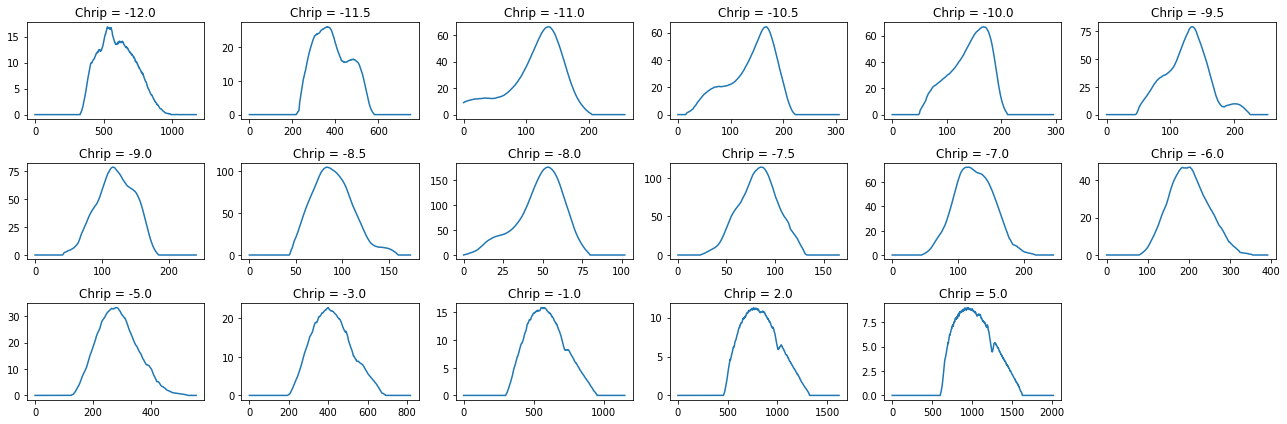

In [30]:
plt.figure(figsize=(18,6))
for i, chirp in enumerate(preprocessed.index.values):
    plt.subplot(3, 6, i+1)
    plt.title(f"Chrip = {chirp}")
    plt.plot(preprocessed[chirp])
plt.tight_layout()
plt.show()

In [3]:
# Get CRISP formfactors

In [4]:
# Unite bunch profiles, CRISP high and CRISP low